# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [3]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/My Drive/Colab Notebooks/CV"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Colab Notebooks/CV" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/Colab Notebooks/CV


# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    if rot == 0: # 0 degrees rotation
        return img
    elif rot == 1: # 90 degrees rotation
        return img.transpose(1, 2).flip(1)
    elif rot == 2: # 180 degrees rotation
        return img.flip(1).flip(2)
    elif rot == 3: # 270 degrees rotation
        return img.transpose(1, 2).flip(2)

    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

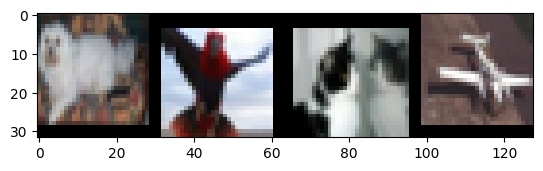

Class labels:  dog   bird  cat   plane


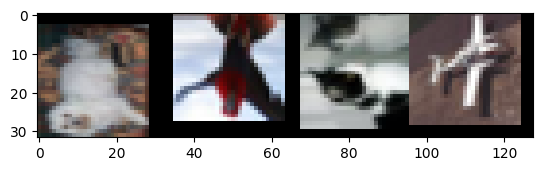

Rotation labels:  90    180   90    90   


In [7]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [8]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction

            outputs = net(images)

            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [9]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [16]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
#
#
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)


In [22]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = None
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.

        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [15]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#
torch.save(net.state_dict(), 'final_project_1.pth')

[1,   100] loss: 1.482 acc: 37.89 time: 7.60
[1,   200] loss: 1.255 acc: 45.08 time: 6.82
[1,   300] loss: 1.159 acc: 48.77 time: 7.13
TESTING:
Accuracy of the network on the 10000 test images: 53.22 %
Average loss on the 10000 test images: 1.090
[2,   100] loss: 1.115 acc: 51.69 time: 7.85
[2,   200] loss: 1.119 acc: 52.12 time: 6.19
[2,   300] loss: 1.077 acc: 53.27 time: 7.70
TESTING:
Accuracy of the network on the 10000 test images: 56.00 %
Average loss on the 10000 test images: 1.035
[3,   100] loss: 1.039 acc: 55.90 time: 7.89
[3,   200] loss: 1.018 acc: 56.42 time: 6.08
[3,   300] loss: 1.017 acc: 57.30 time: 8.13
TESTING:
Accuracy of the network on the 10000 test images: 58.42 %
Average loss on the 10000 test images: 0.988
[4,   100] loss: 0.991 acc: 57.95 time: 7.58
[4,   200] loss: 0.970 acc: 59.30 time: 9.17
[4,   300] loss: 0.973 acc: 59.22 time: 6.33
TESTING:
Accuracy of the network on the 10000 test images: 60.86 %
Average loss on the 10000 test images: 0.933
[5,   100] l

## Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [17]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

# Randomly initialize a ResNet18 model
net = resnet18(num_classes=4)

# Load the pre-trained model from the local directory
pretrained_path = 'final_project_1.pth'
net.load_state_dict(torch.load(pretrained_path))

# Modify the final fully connected layer to match the number of CIFAR-10 classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
for name, param in net.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False



In [19]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [20]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.001)

In [23]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_2_rotation.pth')

[1,   100] loss: 1.870 acc: 29.43 time: 15.38
[1,   200] loss: 1.521 acc: 43.72 time: 7.35
[1,   300] loss: 1.484 acc: 45.79 time: 6.82
TESTING:
Accuracy of the network on the 10000 test images: 47.72 %
Average loss on the 10000 test images: 1.450
[2,   100] loss: 1.407 acc: 49.15 time: 6.29
[2,   200] loss: 1.386 acc: 49.70 time: 6.28
[2,   300] loss: 1.364 acc: 50.08 time: 7.26
TESTING:
Accuracy of the network on the 10000 test images: 50.72 %
Average loss on the 10000 test images: 1.362
[3,   100] loss: 1.345 acc: 51.56 time: 6.54
[3,   200] loss: 1.339 acc: 51.28 time: 5.94
[3,   300] loss: 1.336 acc: 51.34 time: 7.37
TESTING:
Accuracy of the network on the 10000 test images: 52.11 %
Average loss on the 10000 test images: 1.333
[4,   100] loss: 1.315 acc: 51.87 time: 7.85
[4,   200] loss: 1.316 acc: 52.15 time: 8.01
[4,   300] loss: 1.319 acc: 52.16 time: 5.83
TESTING:
Accuracy of the network on the 10000 test images: 52.41 %
Average loss on the 10000 test images: 1.304
[5,   100] 

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10, pretrained=False)

net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
for name, param in net.named_parameters():
    if "layer4" not in name and "fc" not in name:
        param.requires_grad = False



In [29]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [31]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr=0.01)

In [34]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_2_random.pth')

[1,   100] loss: 1.935 acc: 30.91 time: 7.48
[1,   200] loss: 1.903 acc: 31.36 time: 5.82
[1,   300] loss: 1.852 acc: 32.77 time: 7.44
TESTING:
Accuracy of the network on the 10000 test images: 37.57 %
Average loss on the 10000 test images: 1.753
[2,   100] loss: 1.816 acc: 34.44 time: 7.48
[2,   200] loss: 1.810 acc: 34.45 time: 5.74
[2,   300] loss: 1.794 acc: 35.22 time: 7.57
TESTING:
Accuracy of the network on the 10000 test images: 38.48 %
Average loss on the 10000 test images: 1.715
[3,   100] loss: 1.780 acc: 35.58 time: 6.57
[3,   200] loss: 1.766 acc: 36.69 time: 6.47
[3,   300] loss: 1.754 acc: 36.67 time: 8.35
TESTING:
Accuracy of the network on the 10000 test images: 39.20 %
Average loss on the 10000 test images: 1.690
[4,   100] loss: 1.741 acc: 37.55 time: 5.98
[4,   200] loss: 1.759 acc: 36.84 time: 7.68
[4,   300] loss: 1.734 acc: 37.59 time: 5.77
TESTING:
Accuracy of the network on the 10000 test images: 39.73 %
Average loss on the 10000 test images: 1.689
[5,   100] l

## Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
# Randomly initialize a ResNet18 model
net = resnet18(num_classes=4)

# Load the pre-trained model from the local directory
pretrained_path = 'final_project_1.pth'
net.load_state_dict(torch.load(pretrained_path))

# Modify the final fully connected layer to match the number of CIFAR-10 classes
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [38]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_3_rotation.pth')

[1,   100] loss: 1.516 acc: 44.16 time: 8.05
[1,   200] loss: 1.190 acc: 57.17 time: 6.36
[1,   300] loss: 1.106 acc: 61.38 time: 7.92
TESTING:
Accuracy of the network on the 10000 test images: 64.99 %
Average loss on the 10000 test images: 1.008
[2,   100] loss: 0.971 acc: 65.98 time: 7.05
[2,   200] loss: 0.941 acc: 67.12 time: 7.65
[2,   300] loss: 0.900 acc: 68.68 time: 6.78
TESTING:
Accuracy of the network on the 10000 test images: 69.75 %
Average loss on the 10000 test images: 0.879
[3,   100] loss: 0.848 acc: 70.61 time: 6.55
[3,   200] loss: 0.817 acc: 71.59 time: 8.05
[3,   300] loss: 0.808 acc: 72.13 time: 6.36
TESTING:
Accuracy of the network on the 10000 test images: 71.86 %
Average loss on the 10000 test images: 0.832
[4,   100] loss: 0.767 acc: 73.67 time: 7.42
[4,   200] loss: 0.750 acc: 74.03 time: 7.15
[4,   300] loss: 0.740 acc: 74.63 time: 7.35
TESTING:
Accuracy of the network on the 10000 test images: 74.17 %
Average loss on the 10000 test images: 0.764
[5,   100] l

## Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [41]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes = 10, pretrained = False)
net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
# TODO: Define criterion and optimizer
criterion = None
optimizer = None
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [43]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(), 'final_project_3_random.pth')

[1,   100] loss: 2.282 acc: 21.72 time: 6.39
[1,   200] loss: 1.915 acc: 31.50 time: 7.91
[1,   300] loss: 1.775 acc: 35.40 time: 7.29
TESTING:
Accuracy of the network on the 10000 test images: 41.06 %
Average loss on the 10000 test images: 1.578
[2,   100] loss: 1.576 acc: 42.24 time: 7.58
[2,   200] loss: 1.470 acc: 45.60 time: 7.09
[2,   300] loss: 1.464 acc: 46.02 time: 7.21
TESTING:
Accuracy of the network on the 10000 test images: 51.81 %
Average loss on the 10000 test images: 1.314
[3,   100] loss: 1.331 acc: 51.59 time: 8.15
[3,   200] loss: 1.280 acc: 53.74 time: 6.44
[3,   300] loss: 1.235 acc: 55.16 time: 8.00
TESTING:
Accuracy of the network on the 10000 test images: 60.16 %
Average loss on the 10000 test images: 1.127
[4,   100] loss: 1.141 acc: 59.08 time: 7.61
[4,   200] loss: 1.108 acc: 60.30 time: 7.03
[4,   300] loss: 1.079 acc: 61.62 time: 7.32
TESTING:
Accuracy of the network on the 10000 test images: 64.52 %
Average loss on the 10000 test images: 1.010
[5,   100] l